# Test Notebook with XRP Lightcurve

In [1]:
cd ..

/Users/azib/Documents/PhD/Exocomets/automated_exocomet_hunt


In [2]:
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.stats import sigma_clip, sigma_clipped_stats
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from analysis_tools_cython import *
from functools import reduce
import numpy as np
import math
import sys,os
import kplr
import data
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
from matplotlib import pyplot as plt

In [3]:
def import_XRPlightcurve(file_path,sector,clip=3,drop_bad_points=False,ok_flags=[23],mad_plots=False,return_type='pandas'):
    """
    file_path: path to file
    drop_bad_points: Removing outlier points based on MAD thresholds. Default True
    mad_plots: plots MAD derivations
    q: lightcurve quality, default 0 (removes all non-zero quality)
    clip: Sigma to be clipped by; used in conjuction with with drop_bad_points (default 3)

    returns
        - table: Astropy table of lightcurve
        - info: additional information about the lightcurve (TIC ID, camera, etc)
    """
    lc = pd.read_pickle(file_path)
    #print(len(l#c[6]),"length at import") # picked a random array which gives the length of lightcurve
    ## extracting the lightcur#ve data and converting from lists to Series
    for i in range(len(lc)):
        if isinstance(lc[i], np.ndarray):
            lc[i] = pd.Series(lc[i])
    for_df = lc[6:]  # data[0:6] is not relevant in this case.
    columns = [
        "time",
        "raw flux",
        "corrected flux",
        "PCA flux",
        "flux error",
        "quality",
    ]
    df = pd.DataFrame(data=for_df).T 
    df.columns = columns
    table = Table.from_pandas(df)
    return table, lc[0:6]


In [4]:
file = 'tess/tesslc_270577175.pkl'
table,lc_info = import_XRPlightcurve(file,sector=6,return_type='astropy')

In [5]:
q = table['quality'] == 0

Steps:

- Importing MAD related functions.
- Sigma clip statistics + apply the MAD cut threshold.
- Mask: 

In [6]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()
sec = 6
camera = lc_info[4]
mad_arr = mad_df.loc[:len(table)-1,f"{sec}-{camera}"]
sig_clip = sigma_clip(mad_arr,sigma=3,masked=True)
med_sig_clip = np.nanmedian(sig_clip)
rms_sig_clip = np.nanstd(sig_clip)
mad_cut = mad_arr.values < (med_sig_clip + 3*(rms_sig_clip))

# apply mask for bad times not caught in quality = 0
mask = np.ones_like(table['time'], dtype=bool)
for i in bad_times:
    newchunk = (table['time']<i[0])|(table['time']>i[1]) # prints statement if time is within range
    mask = mask & newchunk # applies mask stating if newchunk is True or False

In [7]:
nan_rows = [ i for i in range(len(table)) if
        math.isnan(table[i][2]) or math.isnan(table[i][0]) ] # -> check this 

table.remove_rows(nan_rows)
#print(len(table),"table length after removing nan rows")

# Smooth data by deleting overly 'spikey' points.
spikes = [ i for i in range(1,len(table)-1) if \
        abs(table[i][1] - 0.5*(table[i-1][1]+table[i+1][1])) \
        > 3*abs(table[i+1][1] - table[i-1][1])]

for i in spikes:
    table[i][1] = 0.5*(table[i-1][1] + table[i+1][1])

In [8]:
matched_ind = np.where(~mad_cut) # returns indices of values above MAD threshold
table['quality'][np.array(matched_ind)] = 23 # set quality flag 23

In [9]:
#table = table[mask]
table = table[table['quality'] == 0]

In [10]:
table

time,raw flux,corrected flux,PCA flux,flux error,quality
float64,float64,float64,float64,float64,float64
1469.05418151656,347137.9453125,347154.0474762639,347237.91987667594,16.086005323284652,0.0
1469.0958481427742,347092.8984375,347135.54636229546,347198.3862718676,16.084751257711787,0.0
1469.1375147737685,347078.0546875,347115.2081440332,347179.6375294337,16.08437582534423,0.0
1469.1791814084336,347063.40625,347110.70301108615,347171.5797639444,16.084105451692125,0.0
1469.2000147267115,347040.3671875,347099.42433376826,347159.7510696048,16.08360714588746,0.0
1469.2208480453587,347055.8359375,347101.73745537805,347185.3274688518,16.08409430461067,0.0
1469.2416813641646,347055.9453125,347128.3496696504,347192.7870969444,16.084061812010006,0.0
1469.2625146829143,347056.0546875,347106.312755302,347171.6956814989,16.08394322531925,0.0
1469.2833480013908,347032.3671875,347120.51372485654,347139.5346182437,16.083430209222218,0.0


---

In [11]:
to_clean = remove_zeros(table,'corrected flux')  # removing any zero points
to_clean = to_clean["time", "corrected flux", "quality"]
t, flux, quality, real = clean_data(to_clean)

1001 length of cleaned lightcurve
Timestep of lightcurve:  30.0 minutes.
Maximum transit chance:
   Time = 1479.12 days.
   Duration = 0.15 days.
   T = -6.8
   T/sigma = -4.3
Transit depth = -0.000294
462   n-3*m
504
[3.263224976349443e-08, 3.631564198077475e-08]
Asym score: 0.8986
Quality flags: 0.0
artefact


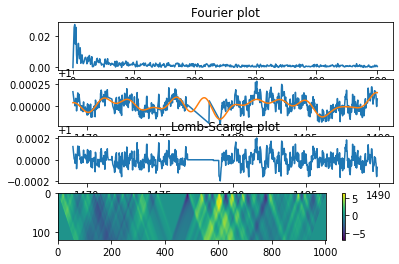

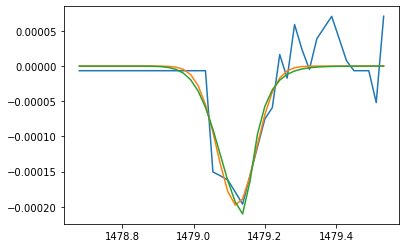

In [12]:
t, flux, quality, real = clean_data(to_clean)

timestep = calculate_timestep(table)

""""The default assumption is a 30-minute cadence."""
factor = ((1/48)/timestep)
 
N = len(t)
print(N,"length of cleaned lightcurve")
ones = np.ones(N)

flux = normalise_flux(flux)

# filteredflux = fourier_filter(flux, 8) # returns smooth lc
A_mag = np.abs(np.fft.rfft(flux))
# periodicnoise = flux - filteredflux


sigma = flux.std()

flux_ls = np.copy(flux)
lombscargle_filter(t, flux_ls, real, 0.05)  # happens in-place. 0.05 is minimum score
periodicnoise_ls = flux - flux_ls
flux_ls = flux_ls * real

# T1 = test_statistic_array(filteredflux, 60)
T = test_statistic_array(flux_ls, 60 * factor)
data = nonzero(T)

# Find minimum test statistic value (m), and its location (n).
m, n = np.unravel_index(T.argmin(), T.shape) # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
minT = T[m, n]
minT_time = t[n]
minT_duration = m * timestep
print("Timestep of lightcurve: ", round(timestep * 1440,3), "minutes.")
print("Maximum transit chance:")
print("   Time =", round(minT_time, 2), "days.")
print("   Duration =", round(minT_duration, 2), "days.")
print("   T =", round(minT, 1))
print("   T/sigma =", round(minT / data.std(), 1))

trans_start = n - math.floor((m - 1) / 2)
trans_end = trans_start + m
print("Transit depth =", round(flux[trans_start:trans_end].mean(), 6))

# Transit shape calculation
if n - 3 * m >= 0 and n + 3 * m < N:  # m: width of point(s) in lc. first part: 3 transit widths away from first data point. last part: not more than 3 transit widths away. 
    t2 = t[n - 3 * m : n + 3 * m]
    x2 = flux_ls[n - 3 * m : n + 3 * m]
    q2 = quality[n - 3 * m : n + 3 * m] # quality points from three transit widths to other edge of three transit widths. 
    background = (sum(x2[: 1 * m]) + sum(x2[5 * m :])) / (2 * m)
    x2 -= background
    paramsgauss = single_gaussian_curve_fit(t2, -x2)
    y2 = -gauss(t2, *paramsgauss)
    paramscomet = comet_curve_fit(t2, -x2)
    w2 = -comet_curve(t2, *paramscomet)

    scores = [score_fit(x2, fit) for fit in [y2, w2]]
    print(scores)
    print("Asym score:", round(scores[0] / scores[1], 4))

    qual_flags = reduce(lambda a, b: a or b, q2) # reduces to single value of quality flags
    print("Quality flags:", qual_flags)

# Classify events
asym, _, _ = calc_shape(m, n, t, flux)
print(classify(m, n, real, asym))



# plt.xkcd()
fig1, axarr = plt.subplots(4)
axarr[0].plot(A_mag)  # fourier plot
axarr[0].title.set_text("Fourier plot")
axarr[1].plot(t, flux + ones, t, periodicnoise_ls + ones)  #
axarr[2].plot(t, flux_ls + ones)  # lomb-scargle plot
axarr[2].title.set_text("Lomb-Scargle plot")

cax = axarr[3].imshow(T)
axarr[3].set_aspect("auto")
fig1.colorbar(cax)

# params = double_gaussian_curve_fit(T)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
# T_test_nonzero = np.array(data)
# _,bins,_ = ax2.hist(T_test_nonzero,bins=100,log=True)
# y = np.maximum(bimodal(bins,*params),10)
# ax2.plot(bins,y)
try:
    ax2.plot(t2, x2, t2, y2, t2, w2)
except:
    pass

plt.show()